### ============================================================================
### NOTEBOOK 02: EXPLORATORY DATA ANALYSIS & FEATURE ENGINEERING
### ============================================================================
### This notebook covers:
###   - 01: EDA - Business Questions (revenue, customers, products, delivery)
###   - 02: EDA - Statistical Analysis (correlations, time series, hypothesis testing)
###   - 03: Feature Engineering (RFM, behavioral, product, seller features)
### ============================================================================

In [1]:
# Setup and Load Clean Data
# ============================================================================
# Import libraries and load the cleaned datasets from Notebook 01
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from pathlib import Path
from datetime import datetime, timedelta
from scipy import stats

# Suppress warnings
warnings.filterwarnings('ignore')

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Create directories for outputs
Path('reports/figures/eda').mkdir(parents=True, exist_ok=True)
Path('data/features').mkdir(parents=True, exist_ok=True)

print("✅ Libraries imported successfully")
print(f"📅 Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported successfully
📅 Analysis date: 2025-11-08 18:42:15


In [2]:
# Load Clean Datasets
# ============================================================================
# Load the cleaned master datasets created in Notebook 01
# ============================================================================

print("📂 LOADING CLEAN DATASETS\n")
print("="*80)

# Load ORDER-LEVEL dataset (for customer/order analysis)
master_order = pd.read_csv('data/processed/master_order_clean.csv')

# Convert dates back to datetime
date_cols = [
    'order_purchase_timestamp', 'order_approved_at', 
    'order_delivered_carrier_date', 'order_delivered_customer_date',
    'order_estimated_delivery_date', 'review_creation_date'
]

for col in date_cols:
    if col in master_order.columns:
        master_order[col] = pd.to_datetime(master_order[col], errors='coerce')

print(f"✅ ORDER-LEVEL loaded: {master_order.shape}")

# Load ITEM-LEVEL dataset (for product/seller analysis)
master_item = pd.read_csv('data/processed/master_item_clean.csv')

# Convert dates
date_cols_item = date_cols + ['shipping_limit_date']
for col in date_cols_item:
    if col in master_item.columns:
        master_item[col] = pd.to_datetime(master_item[col], errors='coerce')

print(f"✅ ITEM-LEVEL loaded: {master_item.shape}")

# Quick verification
print(f"\n📊 Dataset Overview:")
print(f"   Date range: {master_order['order_purchase_timestamp'].min().date()} to {master_order['order_purchase_timestamp'].max().date()}")
print(f"   Total orders: {len(master_order):,}")
print(f"   Total items: {len(master_item):,}")
print(f"   Unique customers: {master_order['customer_unique_id'].nunique():,}")
print(f"   Unique products: {master_item['product_id'].nunique():,}")
print(f"   Total revenue: BRL {master_order['total_payment'].sum():,.2f}")

print("\n✅ Data loaded and ready for analysis!")

📂 LOADING CLEAN DATASETS

✅ ORDER-LEVEL loaded: (99441, 42)
✅ ITEM-LEVEL loaded: (112650, 60)

📊 Dataset Overview:
   Date range: 2016-09-04 to 2018-10-17
   Total orders: 99,441
   Total items: 112,650
   Unique customers: 96,096
   Unique products: 32,951
   Total revenue: BRL 16,008,872.12

✅ Data loaded and ready for analysis!



                    SECTION 04: EDA - BUSINESS QUESTIONS

💰 BUSINESS QUESTION 1: REVENUE TRENDS

Analyzing 96,476 delivered orders
Revenue: BRL 15,421,831.43

📈 Monthly Revenue Summary:
   year_month_str    revenue  order_count  revenue_growth
13        2017-11 1153393.22         7288           53.55
14        2017-12  843199.17         5513          -26.89
15        2018-01 1078606.86         7069           27.92
16        2018-02  966554.97         6556          -10.39
17        2018-03 1120678.00         7003           15.95
18        2018-04 1132933.95         6798            1.09
19        2018-05 1128836.69         6749           -0.36
20        2018-06 1011561.35         6096          -10.39
21        2018-07 1027383.10         6156            1.56
22        2018-08  985414.28         6351           -4.09

📊 Key Metrics:
   Average monthly revenue: BRL 670,514.41
   Peak month: 2017-11 (BRL 1,153,393.22)
   Lowest month: 2016-09 (BRL 0.00)
   Average MoM growth: inf%


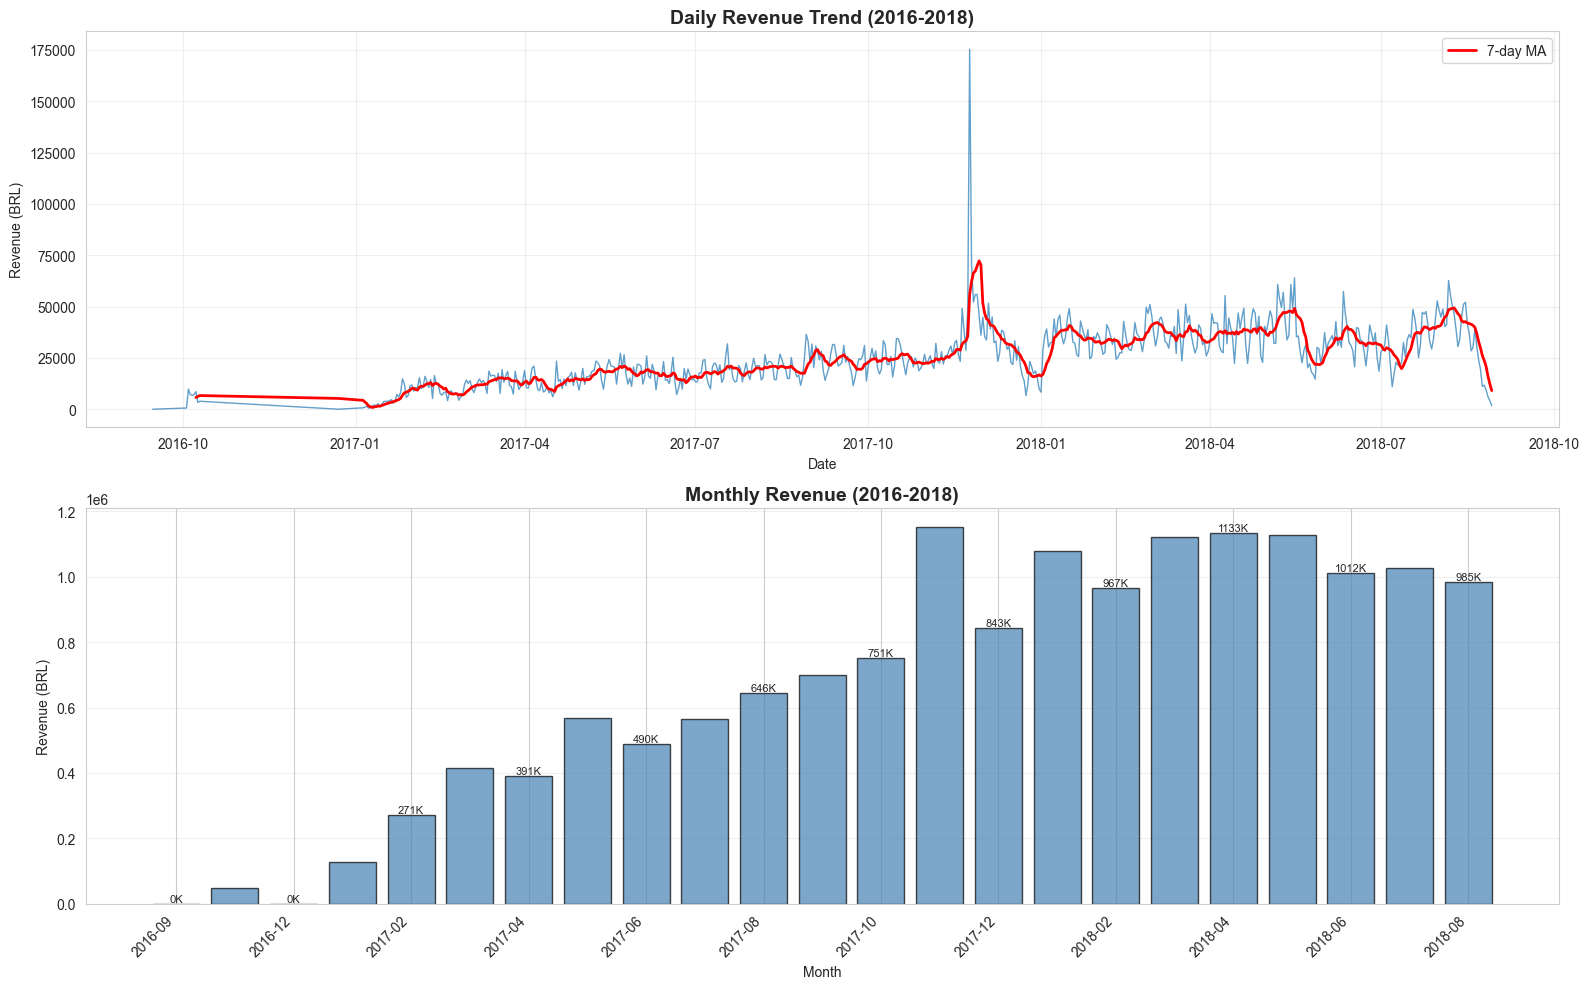


✅ Revenue trend analysis complete
💾 Saved: reports/figures/eda/revenue_trends.png


In [3]:
# Business Question 1 - Revenue Trends
# ============================================================================
# Q: What is the revenue trend over time? Are there seasonal patterns?
# ============================================================================

print("\n" + "="*80)
print(" "*20 + "SECTION 04: EDA - BUSINESS QUESTIONS")
print("="*80)

print("\n💰 BUSINESS QUESTION 1: REVENUE TRENDS")
print("="*80)

# Filter delivered orders for revenue analysis
delivered_orders = master_order[master_order['is_delivered'] == 1].copy()

print(f"\nAnalyzing {len(delivered_orders):,} delivered orders")
print(f"Revenue: BRL {delivered_orders['total_payment'].sum():,.2f}")

# Daily revenue
daily_revenue = delivered_orders.groupby(delivered_orders['order_purchase_timestamp'].dt.date).agg({
    'total_payment': 'sum',
    'order_id': 'count'
}).reset_index()

daily_revenue.columns = ['date', 'revenue', 'order_count']
daily_revenue['date'] = pd.to_datetime(daily_revenue['date'])

# Monthly revenue
delivered_orders['year_month'] = delivered_orders['order_purchase_timestamp'].dt.to_period('M')
monthly_revenue = delivered_orders.groupby('year_month').agg({
    'total_payment': 'sum',
    'order_id': 'count'
}).reset_index()

monthly_revenue.columns = ['year_month', 'revenue', 'order_count']
monthly_revenue['year_month_str'] = monthly_revenue['year_month'].astype(str)

# Calculate growth rates
monthly_revenue['revenue_growth'] = monthly_revenue['revenue'].pct_change() * 100
monthly_revenue['order_growth'] = monthly_revenue['order_count'].pct_change() * 100

print("\n📈 Monthly Revenue Summary:")
print(monthly_revenue[['year_month_str', 'revenue', 'order_count', 'revenue_growth']].tail(10))

print(f"\n📊 Key Metrics:")
print(f"   Average monthly revenue: BRL {monthly_revenue['revenue'].mean():,.2f}")
print(f"   Peak month: {monthly_revenue.loc[monthly_revenue['revenue'].idxmax(), 'year_month_str']} (BRL {monthly_revenue['revenue'].max():,.2f})")
print(f"   Lowest month: {monthly_revenue.loc[monthly_revenue['revenue'].idxmin(), 'year_month_str']} (BRL {monthly_revenue['revenue'].min():,.2f})")
print(f"   Average MoM growth: {monthly_revenue['revenue_growth'].mean():.2f}%")

# Visualize daily revenue trend
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Daily revenue
axes[0].plot(daily_revenue['date'], daily_revenue['revenue'], linewidth=1, alpha=0.7)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Revenue (BRL)')
axes[0].set_title('Daily Revenue Trend (2016-2018)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Add 7-day moving average
daily_revenue['revenue_ma7'] = daily_revenue['revenue'].rolling(window=7).mean()
axes[0].plot(daily_revenue['date'], daily_revenue['revenue_ma7'], color='red', linewidth=2, label='7-day MA')
axes[0].legend()

# Monthly revenue with bars
x_pos = np.arange(len(monthly_revenue))
axes[1].bar(x_pos, monthly_revenue['revenue'], color='steelblue', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Revenue (BRL)')
axes[1].set_title('Monthly Revenue (2016-2018)', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos[::2])  # Show every other month
axes[1].set_xticklabels(monthly_revenue['year_month_str'].iloc[::2], rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on top of bars
for i, v in enumerate(monthly_revenue['revenue']):
    if i % 2 == 0:  # Label every other bar to avoid clutter
        axes[1].text(i, v, f'{v/1000:.0f}K', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('reports/figures/eda/revenue_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Revenue trend analysis complete")
print("💾 Saved: reports/figures/eda/revenue_trends.png")


📅 BUSINESS QUESTION 2: SEASONALITY ANALYSIS

📊 Revenue by Month:
    month month_name        sum   mean  count
0       1    January 1206152.53 154.26   7819
1       2   February 1237853.62 150.79   8209
2       3      March 1535047.39 160.75   9549
3       4      April 1523886.13 167.44   9101
4       5        May 1695709.42 164.73  10294
5       6       June 1501786.95 162.69   9231
6       7       July 1593787.03 158.93  10028
7       8     August 1631414.89 154.72  10544
8       9  September  701169.99 168.96   4150
9      10    October  798411.47 168.16   4748
10     11   November 1153393.22 158.26   7288
11     12   December  843218.79 152.92   5514

📊 Revenue by Day of Week:
   day_of_week   day_name        sum   mean  count
0            0     Monday 2530671.56 161.16  15703
1            1    Tuesday 2473930.77 159.59  15502
2            2  Wednesday 2396215.34 158.96  15074
3            3   Thursday 2283964.44 159.48  14321
4            4     Friday 2223022.52 162.44  13685
5  

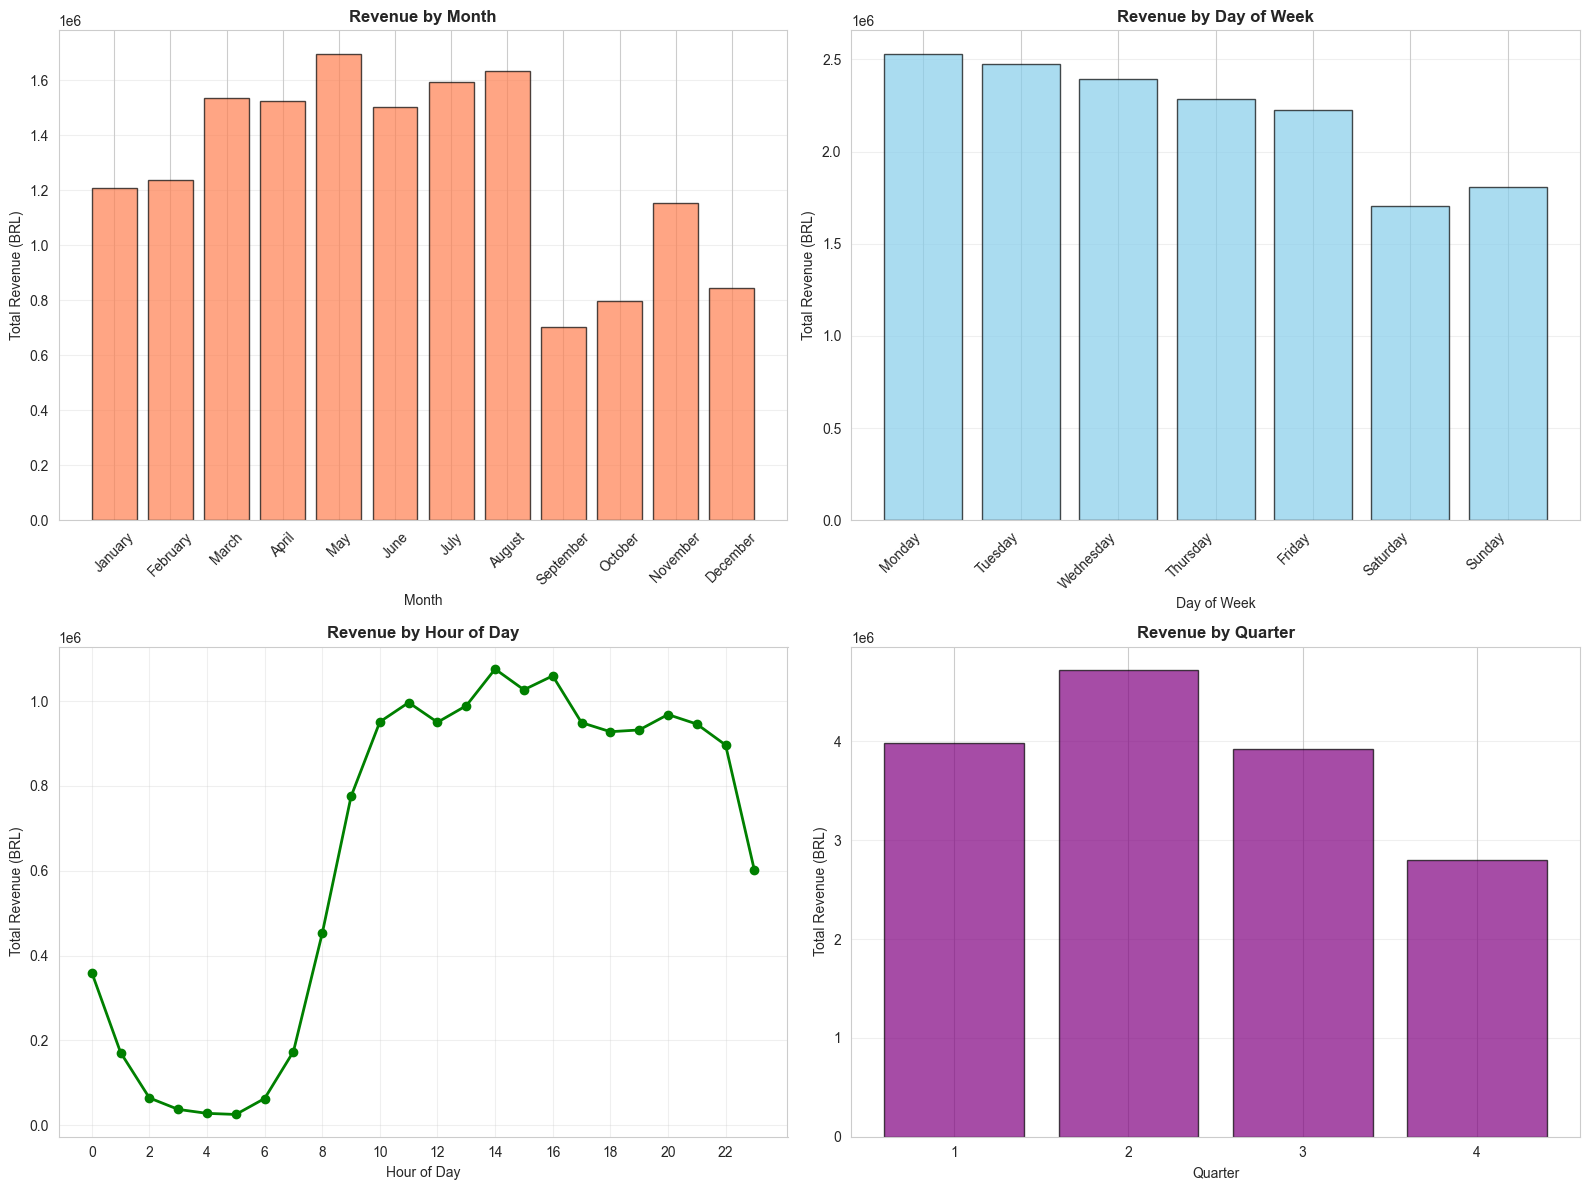


✅ Seasonality analysis complete
💾 Saved: reports/figures/eda/seasonality_patterns.png

🔑 KEY INSIGHTS:
   • Best month: May
   • Best day: Monday
   • Peak hour: 14:00
   • Best quarter: Q2


In [ ]:
# Business Question 2 - Seasonality Analysis
# ============================================================================
# Q: Are there seasonal patterns? Which months/days perform best?
# ============================================================================

print("\n📅 BUSINESS QUESTION 2: SEASONALITY ANALYSIS")
print("="*80)

# Extract time components
delivered_orders['month'] = delivered_orders['order_purchase_timestamp'].dt.month
delivered_orders['month_name'] = delivered_orders['order_purchase_timestamp'].dt.month_name()
delivered_orders['day_of_week'] = delivered_orders['order_purchase_timestamp'].dt.dayofweek
delivered_orders['day_name'] = delivered_orders['order_purchase_timestamp'].dt.day_name()
delivered_orders['hour'] = delivered_orders['order_purchase_timestamp'].dt.hour
delivered_orders['quarter'] = delivered_orders['order_purchase_timestamp'].dt.quarter

# Revenue by month
revenue_by_month = delivered_orders.groupby(['month', 'month_name'])['total_payment'].agg(['sum', 'mean', 'count']).reset_index()
revenue_by_month = revenue_by_month.sort_values('month')

print("\n📊 Revenue by Month:")
print(revenue_by_month)

# Revenue by day of week
revenue_by_dow = delivered_orders.groupby(['day_of_week', 'day_name'])['total_payment'].agg(['sum', 'mean', 'count']).reset_index()
revenue_by_dow = revenue_by_dow.sort_values('day_of_week')

print("\n📊 Revenue by Day of Week:")
print(revenue_by_dow)

# Revenue by hour
revenue_by_hour = delivered_orders.groupby('hour')['total_payment'].agg(['sum', 'mean', 'count']).reset_index()

print("\n📊 Peak Hours:")
print(revenue_by_hour.nlargest(5, 'sum'))

# Check for Black Friday effect (late November)
delivered_orders['is_black_friday_week'] = (
    (delivered_orders['month'] == 11) & 
    (delivered_orders['order_purchase_timestamp'].dt.day >= 20) & 
    (delivered_orders['order_purchase_timestamp'].dt.day <= 27)
)

bf_revenue = delivered_orders[delivered_orders['is_black_friday_week']]['total_payment'].sum()
non_bf_revenue = delivered_orders[~delivered_orders['is_black_friday_week']]['total_payment'].sum()
bf_orders = delivered_orders[delivered_orders['is_black_friday_week']]['order_id'].count()
total_orders = len(delivered_orders)

print(f"\n🛍️ BLACK FRIDAY IMPACT:")
print(f"   Black Friday week orders: {bf_orders:,} ({bf_orders/total_orders*100:.2f}%)")
print(f"   Black Friday week revenue: BRL {bf_revenue:,.2f} ({bf_revenue/(bf_revenue+non_bf_revenue)*100:.2f}%)")

# Visualize seasonality
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Monthly pattern
axes[0, 0].bar(revenue_by_month['month_name'], revenue_by_month['sum'], color='coral', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Total Revenue (BRL)')
axes[0, 0].set_title('Revenue by Month', fontsize=12, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Day of week pattern
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
axes[0, 1].bar(revenue_by_dow['day_name'], revenue_by_dow['sum'], color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Total Revenue (BRL)')
axes[0, 1].set_title('Revenue by Day of Week', fontsize=12, fontweight='bold')
axes[0, 1].set_xticklabels(day_order, rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Hourly pattern
axes[1, 0].plot(revenue_by_hour['hour'], revenue_by_hour['sum'], marker='o', linewidth=2, color='green')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Total Revenue (BRL)')
axes[1, 0].set_title('Revenue by Hour of Day', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(range(0, 24, 2))
axes[1, 0].grid(True, alpha=0.3)

# Quarterly pattern
revenue_by_quarter = delivered_orders.groupby('quarter')['total_payment'].sum()
axes[1, 1].bar(revenue_by_quarter.index, revenue_by_quarter.values, color='purple', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Quarter')
axes[1, 1].set_ylabel('Total Revenue (BRL)')
axes[1, 1].set_title('Revenue by Quarter', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks([1, 2, 3, 4])
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('reports/figures/eda/seasonality_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Seasonality analysis complete")
print("💾 Saved: reports/figures/eda/seasonality_patterns.png")

# Key insights
print("\n🔑 KEY INSIGHTS:")
print(f"   • Best month: {revenue_by_month.loc[revenue_by_month['sum'].idxmax(), 'month_name']}")
print(f"   • Best day: {revenue_by_dow.loc[revenue_by_dow['sum'].idxmax(), 'day_name']}")
print(f"   • Peak hour: {revenue_by_hour.loc[revenue_by_hour['sum'].idxmax(), 'hour']}:00")
print(f"   • Best quarter: Q{revenue_by_quarter.idxmax()}")


👥 BUSINESS QUESTION 3: CUSTOMER BEHAVIOR

📊 CUSTOMER METRICS:
   Total unique customers: 93,356
   Customers with 1 order: 90,555 (97.00%)
   Customers with 2+ orders: 2,801 (3.00%)
   Repeat purchase rate: 3.00%
   Max orders by single customer: 15

💰 CUSTOMER LIFETIME VALUE:
count   93356.00
mean      165.19
std       226.32
min         0.00
25%        63.05
50%       107.78
75%       182.54
90%       318.03
95%       469.63
99%      1097.07
max     13664.08
Name: total_spent, dtype: float64

📈 AVERAGE ORDER VALUE:
count   93356.00
mean      160.31
std       219.57
min         0.00
25%        62.37
50%       105.63
75%       176.65
90%       306.22
95%       447.00
99%      1057.24
max     13664.08
Name: avg_order_value, dtype: float64

📊 CUSTOMER SEGMENTS:
      customer_segment customer_unique_id total_spent        order_count
                                    count         sum   mean         sum
0  Loyal Customer (6+)                 10     8409.06 840.91          75
1       On

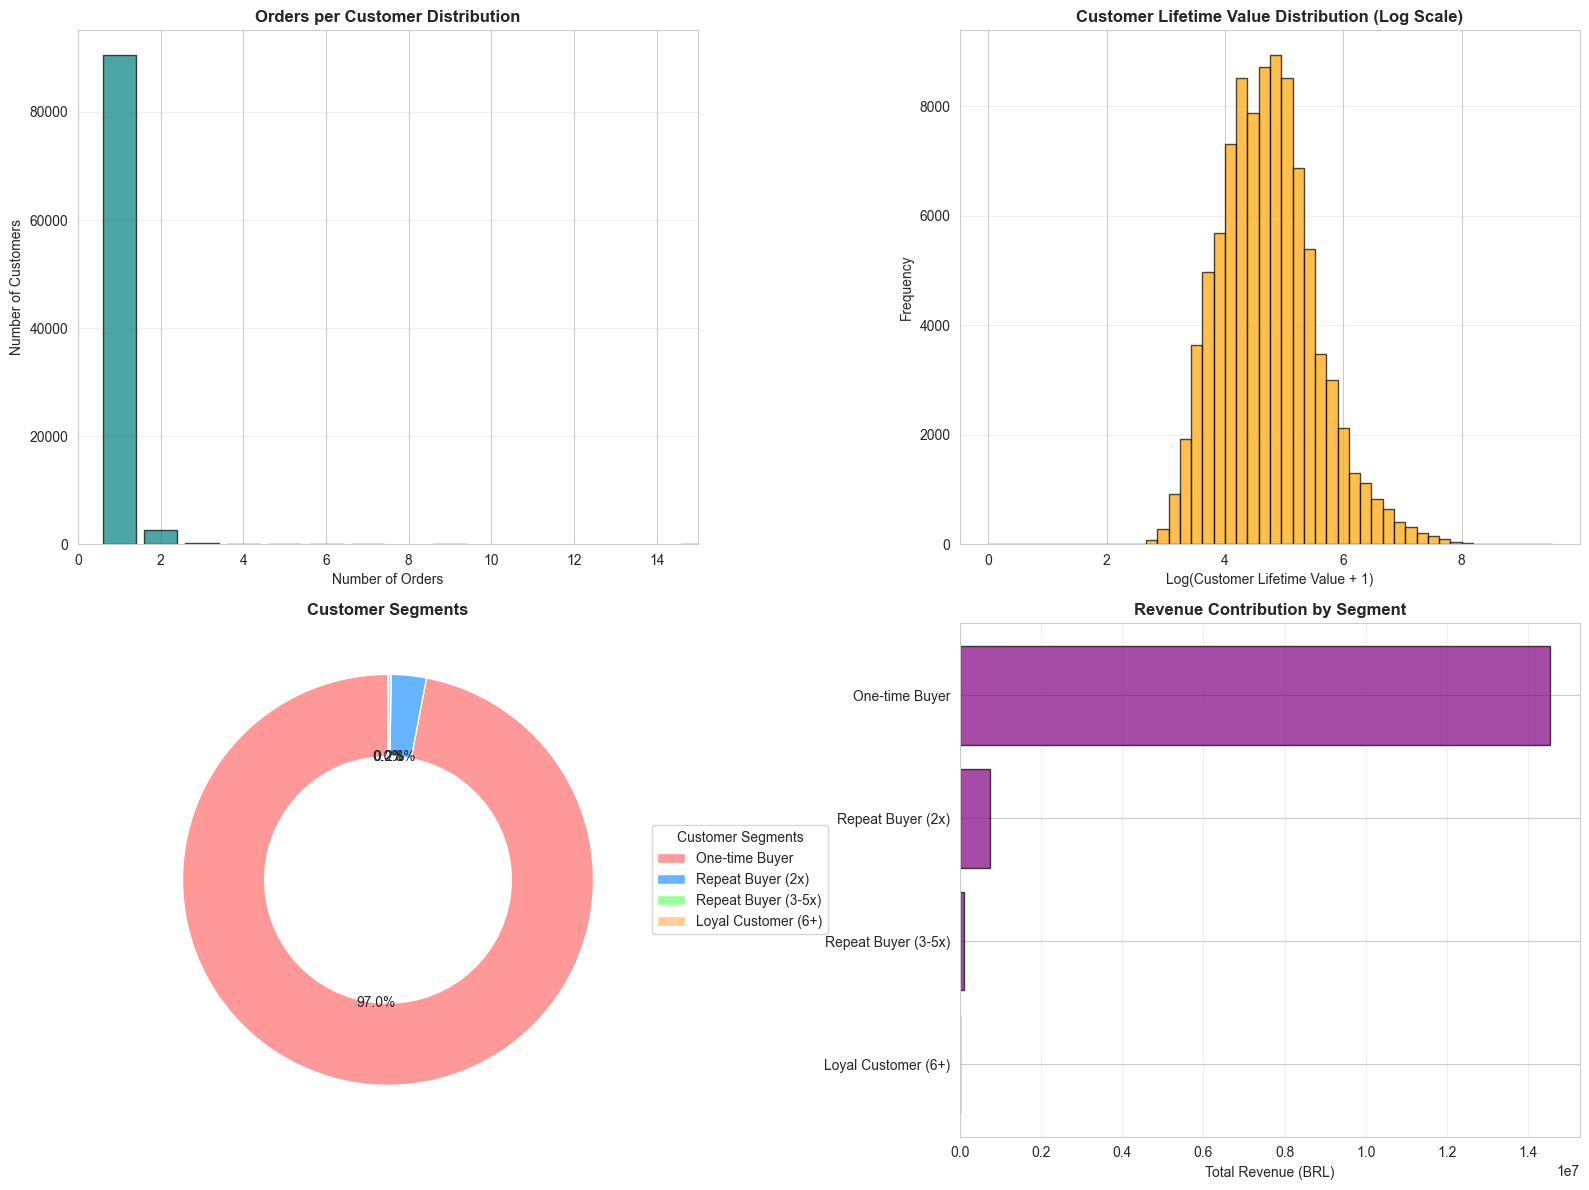


✅ Customer behavior analysis complete
💾 Saved: reports/figures/eda/customer_behavior.png

⚠️  CRITICAL INSIGHT:
   97.0% of customers make ONLY ONE purchase!
   This indicates a MAJOR retention problem - focus area for improvement


In [8]:
# Business Question 3 - Customer Behavior
# ============================================================================
# Q: What is the repeat purchase rate? Customer lifetime value distribution?
# ============================================================================

print("\n👥 BUSINESS QUESTION 3: CUSTOMER BEHAVIOR")
print("="*80)

# Calculate orders per customer (using customer_unique_id)
orders_per_customer = delivered_orders.groupby('customer_unique_id').agg({
    'order_id': 'count',
    'total_payment': 'sum',
    'order_purchase_timestamp': ['min', 'max']
}).reset_index()

orders_per_customer.columns = ['customer_unique_id', 'order_count', 'total_spent', 'first_order_date', 'last_order_date']

# Calculate customer tenure
orders_per_customer['customer_tenure_days'] = (
    orders_per_customer['last_order_date'] - orders_per_customer['first_order_date']
).dt.days

# Calculate CLV metrics
orders_per_customer['avg_order_value'] = orders_per_customer['total_spent'] / orders_per_customer['order_count']

print(f"\n📊 CUSTOMER METRICS:")
print(f"   Total unique customers: {len(orders_per_customer):,}")
print(f"   Customers with 1 order: {(orders_per_customer['order_count'] == 1).sum():,} ({(orders_per_customer['order_count'] == 1).sum()/len(orders_per_customer)*100:.2f}%)")
print(f"   Customers with 2+ orders: {(orders_per_customer['order_count'] >= 2).sum():,} ({(orders_per_customer['order_count'] >= 2).sum()/len(orders_per_customer)*100:.2f}%)")
print(f"   Repeat purchase rate: {(orders_per_customer['order_count'] > 1).sum()/len(orders_per_customer)*100:.2f}%")
print(f"   Max orders by single customer: {orders_per_customer['order_count'].max()}")

print(f"\n💰 CUSTOMER LIFETIME VALUE:")
print(orders_per_customer['total_spent'].describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99]))

print(f"\n📈 AVERAGE ORDER VALUE:")
print(orders_per_customer['avg_order_value'].describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99]))

# Segment customers
def segment_customer(row):
    if row['order_count'] == 1:
        return 'One-time Buyer'
    elif row['order_count'] == 2:
        return 'Repeat Buyer (2x)'
    elif row['order_count'] <= 5:
        return 'Repeat Buyer (3-5x)'
    else:
        return 'Loyal Customer (6+)'

orders_per_customer['customer_segment'] = orders_per_customer.apply(segment_customer, axis=1)

segment_summary = orders_per_customer.groupby('customer_segment').agg({
    'customer_unique_id': 'count',
    'total_spent': ['sum', 'mean'],
    'order_count': 'sum'
}).reset_index()

print(f"\n📊 CUSTOMER SEGMENTS:")
print(segment_summary)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Orders per customer distribution
order_counts = orders_per_customer['order_count'].value_counts().sort_index()
axes[0, 0].bar(order_counts.index, order_counts.values, color='teal', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Number of Orders')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].set_title('Orders per Customer Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlim(0, min(15, order_counts.index.max()))
axes[0, 0].grid(True, alpha=0.3, axis='y')

# CLV distribution (log scale)
axes[0, 1].hist(np.log1p(orders_per_customer['total_spent']), bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Log(Customer Lifetime Value + 1)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Customer Lifetime Value Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# ✅ Improved Customer Segments (Donut Chart + Legend)
segment_counts = orders_per_customer['customer_segment'].value_counts()
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

wedges, texts, autotexts = axes[1, 0].pie(
    segment_counts.values,
    labels=None,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    wedgeprops=dict(width=0.4, edgecolor='white')
)

# Add legend outside for readability
axes[1, 0].legend(
    segment_counts.index,
    title="Customer Segments",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

axes[1, 0].set_title('Customer Segments', fontsize=12, fontweight='bold')
axes[1, 0].set_aspect('equal')

# Revenue by segment
segment_revenue = orders_per_customer.groupby('customer_segment')['total_spent'].sum().sort_values(ascending=True)
axes[1, 1].barh(range(len(segment_revenue)), segment_revenue.values, color='purple', edgecolor='black', alpha=0.7)
axes[1, 1].set_yticks(range(len(segment_revenue)))
axes[1, 1].set_yticklabels(segment_revenue.index)
axes[1, 1].set_xlabel('Total Revenue (BRL)')
axes[1, 1].set_title('Revenue Contribution by Segment', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('reports/figures/eda/customer_behavior.png', dpi=300, bbox_inches='tight')
plt.show()


print("\n✅ Customer behavior analysis complete")
print("💾 Saved: reports/figures/eda/customer_behavior.png")

# Critical insight
print("\n⚠️  CRITICAL INSIGHT:")
one_time_pct = (orders_per_customer['order_count'] == 1).sum()/len(orders_per_customer)*100
print(f"   {one_time_pct:.1f}% of customers make ONLY ONE purchase!")
print(f"   This indicates a MAJOR retention problem - focus area for improvement")


🛍️ BUSINESS QUESTION 4: PRODUCT PERFORMANCE

📊 Top 15 Categories by Revenue:
                 category  total_revenue  total_items_sold  avg_price
43          health_beauty     1258681.34              9670     130.16
71          watches_gifts     1205005.68              5991     201.14
7          bed_bath_table     1036988.68             11115      93.30
65         sports_leisure      988048.97              8641     114.34
15  computers_accessories      911954.32              7827     116.51
39        furniture_decor      729762.49              8334      87.56
20             cool_stuff      635290.85              3796     167.36
49             housewares      632248.66              6964      90.79
5                    auto      592720.11              4235     139.96
42           garden_tools      485256.46              4347     111.63
69                   toys      483946.60              4117     117.55
6                    baby      411764.89              3065     134.34
59          

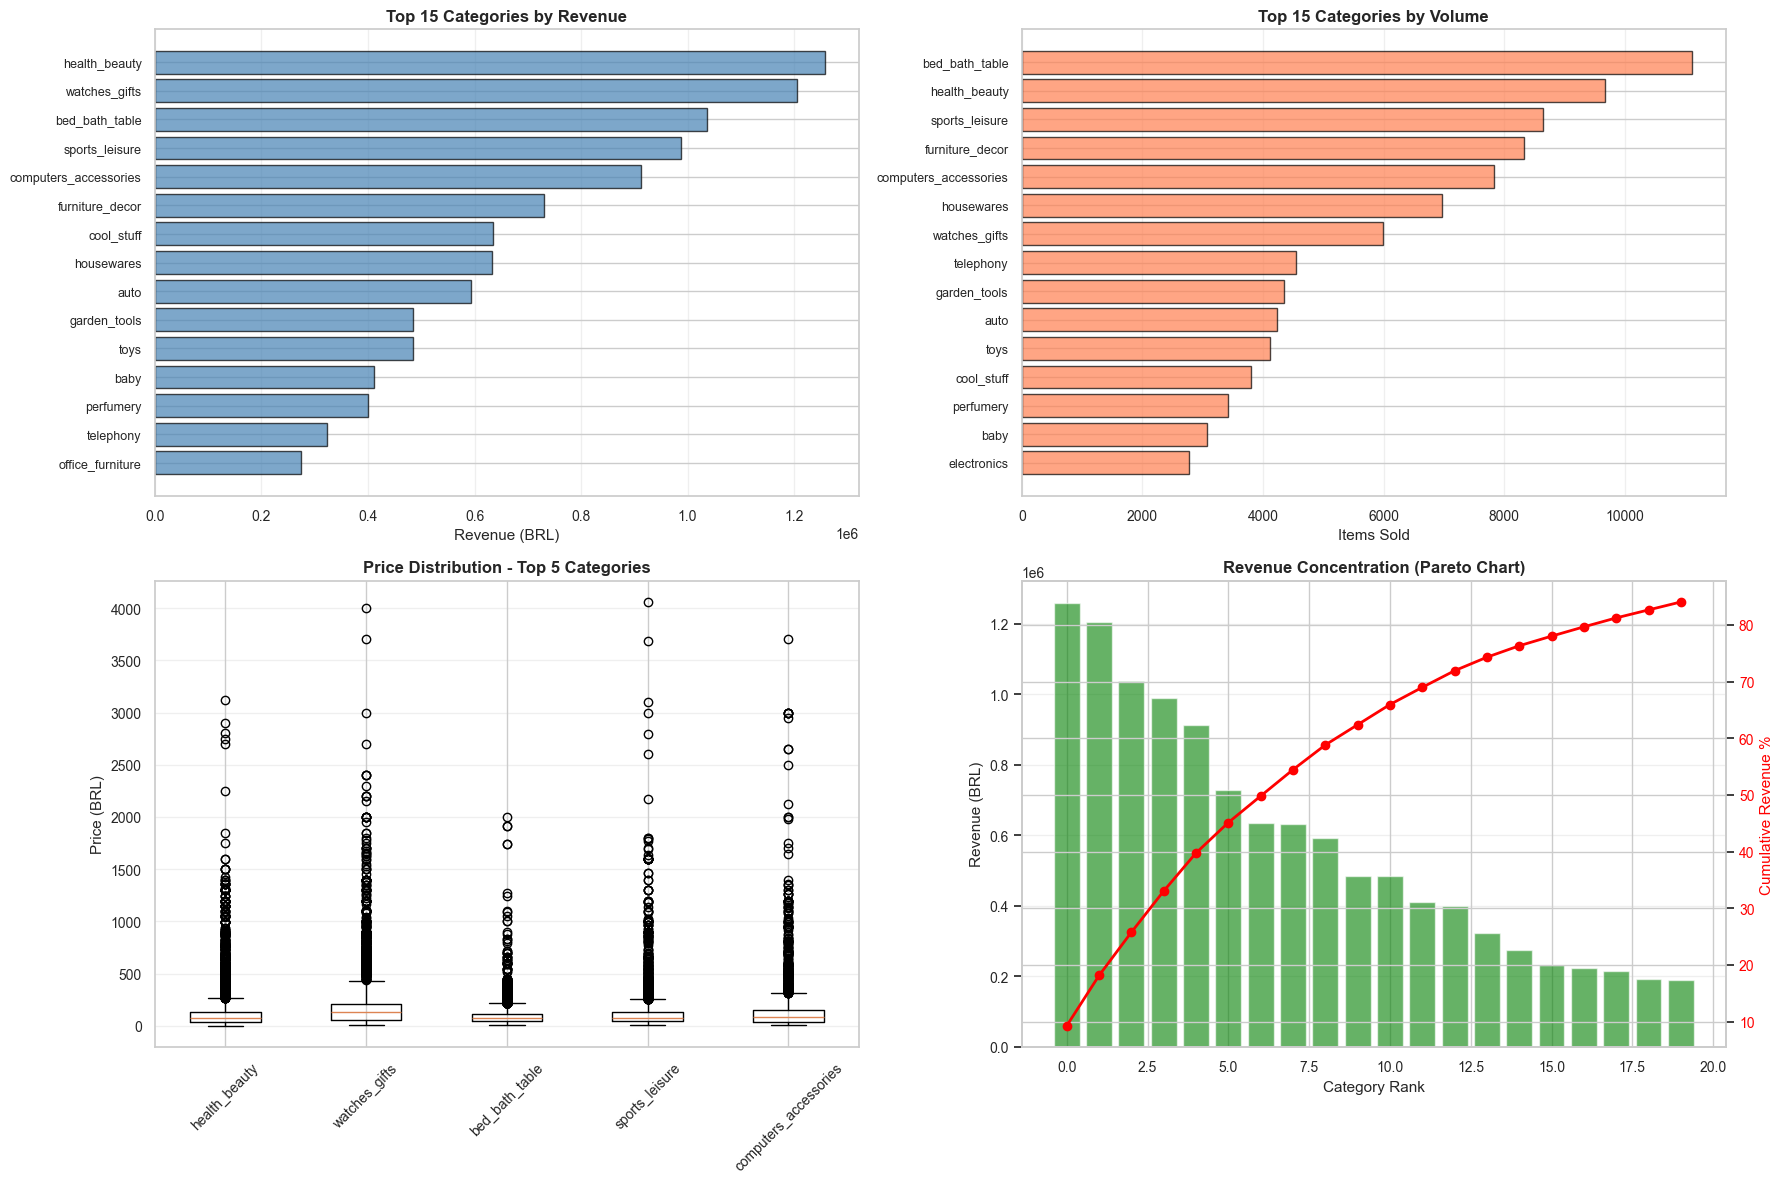


✅ Product performance analysis complete
💾 Saved: reports/figures/eda/product_performance.png


In [10]:
# Business Question 4 - Product Performance
# ============================================================================
# Q: Which product categories drive revenue? Which are most popular?
# ============================================================================

print("\n🛍️ BUSINESS QUESTION 4: PRODUCT PERFORMANCE")
print("="*80)

# Analyze by category
category_performance = master_item.groupby('product_category_name_english').agg({
    'order_id': 'count',
    'price': ['sum', 'mean'],
    'product_id': 'nunique'
}).reset_index()

category_performance.columns = ['category', 'total_items_sold', 'total_revenue', 'avg_price', 'unique_products']
category_performance = category_performance.sort_values('total_revenue', ascending=False)

print(f"\n📊 Top 15 Categories by Revenue:")
print(category_performance.head(15)[['category', 'total_revenue', 'total_items_sold', 'avg_price']])

print(f"\n📊 Top 15 Categories by Volume:")
print(category_performance.sort_values('total_items_sold', ascending=False).head(15)[['category', 'total_items_sold', 'total_revenue']])

# Calculate category concentration
top_10_revenue = category_performance.head(10)['total_revenue'].sum()
total_revenue_cat = category_performance['total_revenue'].sum()
print(f"\n📈 Category Concentration:")
print(f"   Top 10 categories: BRL {top_10_revenue:,.2f} ({top_10_revenue/total_revenue_cat*100:.1f}% of total)")
print(f"   Total categories: {len(category_performance)}")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top 15 by revenue
top_15_rev = category_performance.head(15)
axes[0, 0].barh(range(len(top_15_rev)), top_15_rev['total_revenue'], color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_yticks(range(len(top_15_rev)))
axes[0, 0].set_yticklabels(top_15_rev['category'], fontsize=9)
axes[0, 0].set_xlabel('Revenue (BRL)')
axes[0, 0].set_title('Top 15 Categories by Revenue', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Top 15 by volume
top_15_vol = category_performance.sort_values('total_items_sold', ascending=False).head(15)
axes[0, 1].barh(range(len(top_15_vol)), top_15_vol['total_items_sold'], color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_yticks(range(len(top_15_vol)))
axes[0, 1].set_yticklabels(top_15_vol['category'], fontsize=9)
axes[0, 1].set_xlabel('Items Sold')
axes[0, 1].set_title('Top 15 Categories by Volume', fontsize=12, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Price distribution by top categories
top_5_categories = category_performance.head(5)['category'].tolist()
price_data_top5 = master_item[master_item['product_category_name_english'].isin(top_5_categories)]

axes[1, 0].boxplot([price_data_top5[price_data_top5['product_category_name_english'] == cat]['price'].dropna() 
                     for cat in top_5_categories], 
                    labels=top_5_categories, vert=True)
axes[1, 0].set_ylabel('Price (BRL)')
axes[1, 0].set_title('Price Distribution - Top 5 Categories', fontsize=12, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Revenue concentration (Pareto chart)
category_performance_sorted = category_performance.sort_values('total_revenue', ascending=False).reset_index(drop=True)
category_performance_sorted['cumulative_revenue'] = category_performance_sorted['total_revenue'].cumsum()
category_performance_sorted['cumulative_pct'] = (category_performance_sorted['cumulative_revenue'] / 
                                                  category_performance_sorted['total_revenue'].sum() * 100)

axes[1, 1].bar(range(20), category_performance_sorted.head(20)['total_revenue'], color='green', alpha=0.6, label='Revenue')
ax2 = axes[1, 1].twinx()
ax2.plot(range(20), category_performance_sorted.head(20)['cumulative_pct'], color='red', marker='o', linewidth=2, label='Cumulative %')
ax2.set_ylabel('Cumulative Revenue %', color='red')
ax2.tick_params(axis='y', labelcolor='red')
axes[1, 1].set_xlabel('Category Rank')
axes[1, 1].set_ylabel('Revenue (BRL)')
axes[1, 1].set_title('Revenue Concentration (Pareto Chart)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('reports/figures/eda/product_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Product performance analysis complete")
print("💾 Saved: reports/figures/eda/product_performance.png")